In [6]:
import numpy as np

In [12]:
data = np.load('./annotations/cs/cs4pc_256_train.npy', allow_pickle=True).item()

In [13]:
for i in range(len(data['images'])):
    tmp = data['images'][i]['file_name'].replace('/cs4pc_256/', '/vision/images/cs/cs4pc_256/')
    data['images'][i]['file_name'] = tmp
data['images'][0]

{'file_name': '/mnt/lwll/lwll-coral/hrant/vision/images/cs/cs4pc_256/train/krefeld_000000_011655_leftImg8bit.256_0_0.png',
 'height': 256,
 'width': 256,
 'id': 0,
 'black_image': array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 4, 4, 4],
        [3, 3, 3, ..., 4, 4, 4],
        [3, 3, 3, ..., 4, 4, 4]], dtype=uint8),
 'patch_labels': array([ 2, 17, 17, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  2, 17, 17,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  2, 17, 17, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11,  2, 17, 17, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11,  2, 17, 17, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11,  2, 17, 17, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  2,
        17, 17, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  2, 17, 17, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  2, 17, 17, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11,  2, 17, 17,

In [14]:
np.save('./annotations/cs/cs4pc_256_train.npy', data)

In [2]:
import os

In [3]:
import sys
sys.path.append('../')

In [4]:
import torch
from util.get_dataloader import get_dataloader

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to('cuda')

dataloader, dataloader_val, num_classes, dataset = get_dataloader(dataset_name='f1m', \
            train_annotation_file='./annotations/f1m/250_8shot_train.npy', \
            val_annotation_file='./annotations/f1m/250_8shot_val.npy', \
            batch_size=20, weighted=False, resize_image=True, n_patches=16)

Using cache found in /home/hkhachatrian/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [5]:
def dinov2(model, x):
    x = model.prepare_tokens_with_masks(x)
    for i, blk in enumerate(model.blocks):
        x = blk(x)
#     print(i)
    x = model.norm(x)
    return x

In [6]:
from tqdm.notebook import tqdm

In [46]:
model_name = 'dinov2'
num_classes = 33
pathTrain = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model_name}_7_embeds_train_72.npy'
pathVal = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model_name}_7_embeds_val_30.npy' 

pathLabelsTrain = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model_name}_7_labels_train_72.npy'
pathLabelsVal = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model_name}_7_labels_val_30.npy' 

In [7]:
model_name = 'dinov2'
num_classes = 6
pathTrain = f'/mnt/lwll/lwll-coral/hrant/embeddings/fair1m/{model_name}_250_8shot_embeds_train.npy'
pathVal = f'/mnt/lwll/lwll-coral/hrant/embeddings/fair1m/{model_name}_250_8shot_embeds_val.npy' 

pathLabelsTrain = f'/mnt/lwll/lwll-coral/hrant/embeddings/fair1m/{model_name}_250_8shot_labels_train.npy'
pathLabelsVal = f'/mnt/lwll/lwll-coral/hrant/embeddings/fair1m/{model_name}_250_8shot_labels_val.npy' 

In [8]:
embeds = []
labels = []
for ds in tqdm(dataloader, total=len(dataloader)):
    img = torch.einsum('nhwc->nchw', ds['image'])
    img_enc = dinov2(model, img.float().cuda())
    # cls_token = img_enc[:, :1, :].repeat(1, 256, 1)
    img_enc = img_enc[:, 1:, :]
    embeds.append(img_enc.cpu().detach().numpy())
    # embeds.append(torch.cat((img_enc, cls_token), dim=-1).cpu().detach().numpy())
    labels.append(ds['patch_16x16'].detach().numpy())
    # labels.append(ds['indices_labels'].detach().numpy())

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
labels[0].shape

(20, 256)

In [10]:
embs = np.concatenate(embeds, axis=0).reshape(-1, embeds[0].shape[-1])
labs = np.concatenate(labels, axis=0).reshape(-1)   

np.save(pathTrain, embs)
np.save(pathLabelsTrain, labs)

In [11]:
embs.shape, labs.shape

((10240, 768), (10240,))

In [12]:
embeds_val = []
labels_val = []
for ds in tqdm(dataloader_val, total=len(dataloader_val)):
    img = torch.einsum('nhwc->nchw', ds['image'])
    img_enc = dinov2(model, img.float().cuda())
    # cls_token = img_enc[:, :1, :].repeat(1, 256, 1)
    img_enc = img_enc[:, 1:, :]
    embeds_val.append(img_enc.cpu().detach().numpy())
    # embeds_val.append(torch.cat((img_enc, cls_token), dim=-1).cpu().detach().numpy())
    labels_val.append(ds['patch_16x16'].detach().numpy())
#     labels_val.append(ds['indices_labels'].detach().numpy())
    
embs_val = np.concatenate(embeds_val, axis=0).reshape(-1, embeds_val[0].shape[-1])
labs_val = np.concatenate(labels_val, axis=0).reshape(-1)

np.save(pathVal, embs_val)
np.save(pathLabelsVal, labs_val)

  0%|          | 0/2 [00:00<?, ?it/s]

In [54]:
pathTrain

'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/dinov2_7_embeds_train_72.npy'

In [55]:
model_name = 'dinov2'
num_classes = 33
# pathTrain = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model}_embeds_train_72.npy'
# pathVal = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model}_embeds_val_30.npy' 

# pathLabelsTrain = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model}_labels_train_72.npy'
# pathLabelsVal = f'/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/{model}_labels_val_30.npy' 

XTrain_orig = np.load(pathTrain)
XValidation_orig = np.load(pathVal)

yTrain = np.load(pathLabelsTrain)
yVal = np.load(pathLabelsVal)

XTrain = XTrain_orig
XValidation = XValidation_orig

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=1, n_jobs=8, metric='cosine')
knn_model.fit(XTrain, yTrain);

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_val = knn_model.predict(XValidation)

In [59]:
preds_val.shape

(245760,)

In [ ]:
import matplotlib.pyplot as plt

In [60]:
preds_val.reshape(960, -1).shape

(960, 256)

In [58]:
preds_val.shape

(245760,)

In [57]:
model

'dinov2_cat'

In [59]:
print(preds_val.shape)

predictions = preds_val.reshape(-1, 256)
annots = np.load('../annotations/cs4pc_256_val.npy', allow_pickle=True).item()
for i, preds in enumerate(predictions):
    annots['images'][i]['patch_labels_gt'] = annots['images'][i]['patch_labels']
    annots['images'][i]['patch_labels'] = preds
np.save(f'../annotations/cs_256_{model}_val_pred_knn.npy', annots)

(245760,)


In [16]:
preds.shape

(256,)

In [ ]:
import numpy as np

data = np.load('./ann')

In [77]:
import matplotlib.pyplot as plt

In [78]:
model = 'dinov2'
l = 8
layer8 = np.load(f'./embeddings/cs_patches_256/{model}_cs4pc_256_train_{l}_embeds.npy', allow_pickle=True)
layer9 = np.load(f'./embeddings/cs_patches_256/{model}_cs4pc_256_train_{l+1}_embeds.npy', allow_pickle=True)

In [79]:
layer8.shape

(589824, 768)

In [80]:
img8 = layer8[:196, :]
img9 = layer9[:196, :]

In [83]:
from sklearn.decomposition import PCA

pca2 = PCA(2)
img_pca8 = pca2.fit(layer8)
img_pca9 = pca2.fit(layer9)

img_new8 = img_pca8.fit_transform(img8)
img_new9 = img_pca9.fit_transform(img9)

In [84]:
img_new8.shape

(196, 2)

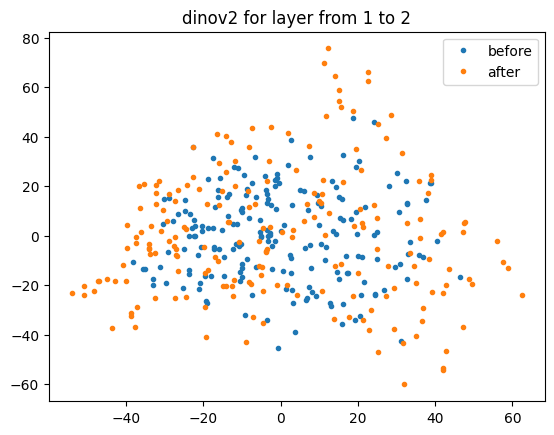

In [53]:
plt.title(f'{model} for layer from {l} to {l+1}')
plt.plot(img_new8[:, 0], img_new8[:, 1], '.', label='before')
plt.plot(img_new9[:, 0], img_new9[:, 1], '.', label='after')
plt.legend();

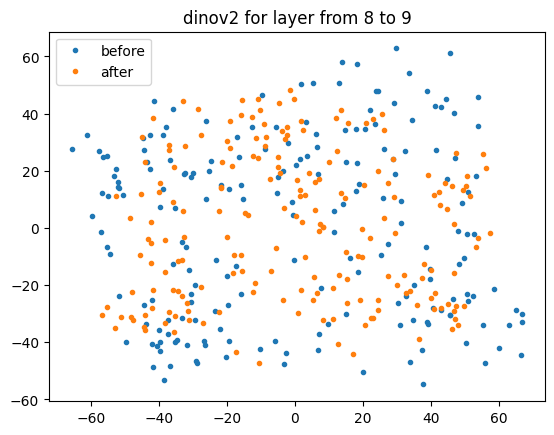

In [85]:
plt.title(f'{model} for layer from {l} to {l+1}')
plt.plot(img_new8[:, 0], img_new8[:, 1], '.', label='before')
plt.plot(img_new9[:, 0], img_new9[:, 1], '.', label='after')
plt.legend();

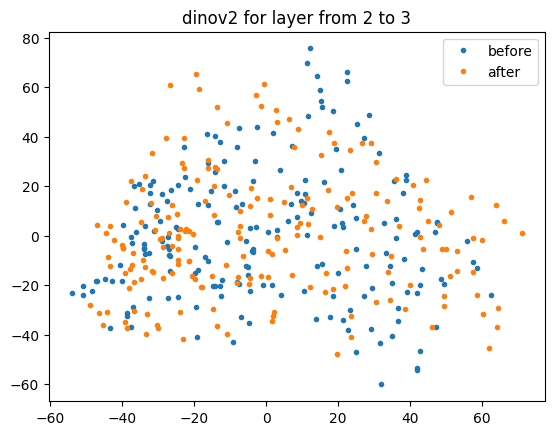

In [59]:
plt.title(f'{model} for layer from {l} to {l+1}')
plt.plot(img_new8[:, 0], img_new8[:, 1], '.', label='before')
plt.plot(img_new9[:, 0], img_new9[:, 1], '.', label='after')
plt.legend();

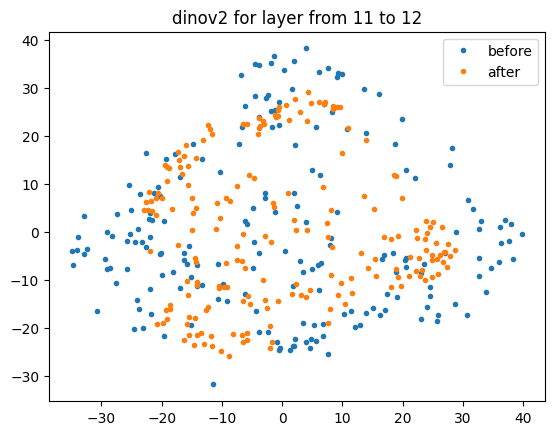

In [64]:
plt.title(f'{model} for layer from {l} to {l+1}')
plt.plot(img_new8[:, 0], img_new8[:, 1], '.', label='before')
plt.plot(img_new9[:, 0], img_new9[:, 1], '.', label='after')
plt.legend();

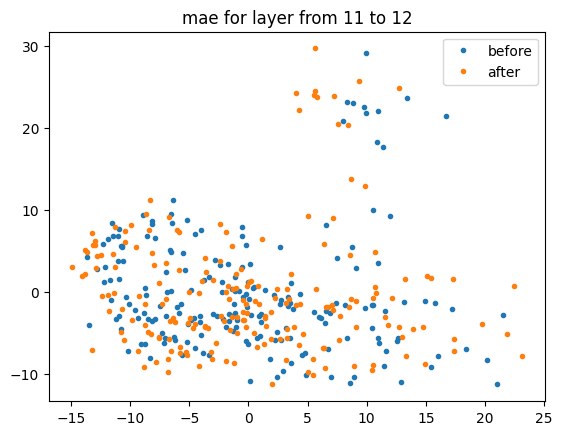

In [69]:
plt.title(f'{model} for layer from {l} to {l+1}')
plt.plot(img_new8[:, 0], img_new8[:, 1], '.', label='before')
plt.plot(img_new9[:, 0], img_new9[:, 1], '.', label='after')
plt.legend();

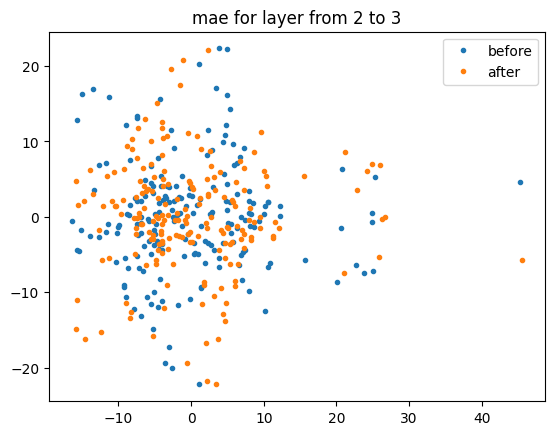

In [73]:
plt.title(f'{model} for layer from {l} to {l+1}')
plt.plot(img_new8[:, 0], img_new8[:, 1], '.', label='before')
plt.plot(img_new9[:, 0], img_new9[:, 1], '.', label='after')
plt.legend();

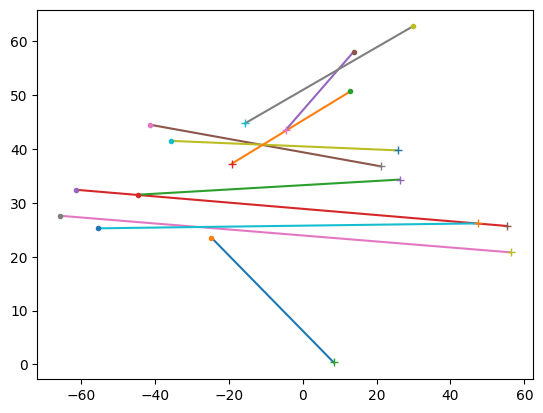

In [90]:
plt.figure()
for i in range(10): #range(img_new8.shape[0]):
    plt.plot((img_new8[i][0], img_new9[i][0]), (img_new8[i][1], img_new9[i][1]))
    plt.plot(img_new8[i][0], img_new8[i][1], '.')
    plt.plot(img_new9[i][0], img_new9[i][1], '+')    